In [20]:
import pandas as pd
import numpy as np
from functools import reduce
import datetime
from datetime import timedelta
import pymysql
from sqlalchemy import create_engine
# 导入模型
import xgboost as xgb
#模型调参的工具
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import GridSearchCV
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
#Error metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pylab as plt

In [21]:
# 数据库信息
mysql_setting = {
    'host': '47.100.201.211',
    'port': 3306,
    'user': 'root',
    'passwd': 'iyGfLR64Ne4Ddhk7',
    # 数据库名称
    'db': 'data',
    'charset': 'utf8'
}
engine = create_engine("mysql+pymysql://{user}:{passwd}@{host}:{port}/{db}".format(**mysql_setting), max_overflow=5)

In [22]:
sql_cmd = "SELECT 时间,市场,当日价格 FROM data.canmi where 市场 like '%合肥%'"
dt = pd.read_sql(sql=sql_cmd, con=engine,parse_dates=0,coerce_float=2)
df = dt.loc[dt['市场']=='合肥周谷堆农产品批发市场股份有限公司'].groupby('时间').mean('当日价格')

In [23]:
def mov_df(df, num):
    df['mov_ori_avg'] = df['orign_price'].transform(lambda x: x.rolling(num).mean())
    df['mov_ori_max'] = df['orign_price'].transform(lambda x: x.rolling(num).max())
    df['mov_ori_min'] = df['orign_price'].transform(lambda x: x.rolling(num).min())
    df['mov_ori_var'] = df['orign_price'].transform(lambda x: x.rolling(num).var())
    return df
def mov_rate(df):
    df['滑窗产地价格波动'] = df['mov_ori_avg'].diff(periods=1)
    l1 = df['mov_ori_avg'].tolist()
    l2 = df['滑窗产地价格波动'].tolist()
    def rate(list1, list2):
        l = ['','','','','']
        i = 5
        while i <= len(list2)-1:
            r = list2[i]/list1[i-1]
            l.append(r)
            i = i + 1
        return l
    df['滑窗产地价格波动率'] = rate(l1, l2)
    df['滑窗产地价格波动率'] = pd.to_numeric(df['滑窗产地价格波动率'])
    return df
def train(df):
    x_train = df.iloc[5:-12,2:]
    y_train = df.iloc[5:-12,1]
    x_train = x_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    x_predict = df.iloc[-12:,2:]
    x_predict = x_predict.reset_index(drop=True)
    y_predict = df.iloc[-12:,1]
    y_predict = y_predict.reset_index(drop=True)
    return [x_train, y_train, x_predict,y_predict]

In [24]:
df.reset_index(level=0, inplace=True)
df.rename(columns={'时间':'date','当日价格':'orign_price'},inplace=True)
def deleteErrorDate(df):
    df.drop(df[df['date']=='2019-02-29'].index, inplace= True)
    df.drop(df[df['date']=='2019-02-30'].index, inplace= True)
    df.drop(df[df['date']=='2019-02-31'].index, inplace= True)    
    df.drop(df[df['date']=='2020-02-30'].index, inplace= True)  
    df.drop(df[df['date']=='2020-02-31'].index, inplace= True)  
    df.drop(df[df['date']=='2021-02-29'].index, inplace= True)  
    df.drop(df[df['date']=='2021-02-30'].index, inplace= True)  
    df.drop(df[df['date']=='2021-02-31'].index, inplace= True) 
    df.drop(df[df['date']=='2022-02-29'].index, inplace= True)  
    df.drop(df[df['date']=='2022-02-30'].index, inplace= True)  
    df.drop(df[df['date']=='2022-02-31'].index, inplace= True) 
    df.drop(df[df['date']=='2021-04-31'].index, inplace= True) 
    return df
df = deleteErrorDate(df)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime("%Y-%m")
df = df.groupby('date').mean('orign_price').round(2)
df.reset_index(level=0, inplace=True)
mov_df(df, 5)
mov_rate(df)
x_train = train(df)[0]
y_train = train(df)[1]
x_predict = train(df)[2]
y_predict = train(df)[3]

In [25]:
rf = RandomForestRegressor(n_jobs = -1, max_depth = 5)
boruta = BorutaPy(
   estimator = rf, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)
# 模型训练
boruta.fit(np.array(x_train), np.array(y_train))
# 输出结果
green_area = x_train.columns[boruta.support_].to_list()
blue_area  = x_train.columns[boruta.support_weak_].to_list()
# 选择最优参数
#重新选择特征
f = []
f.extend(green_area)
f.extend(blue_area)
x_train = x_train[f]
x_predict = x_predict[f]

In [7]:
# setup regressor
xgb_model = xgb.XGBRegressor() 
# performance a grid search
tweaked_model = GridSearchCV(
    xgb_model,   
    {
        'max_depth':[1,2,5,10,20],
        'n_estimators':[20,30,50,70,100],
        'learning_rate':[0.1,0.2,0.3,0.4,0.5]
    },   
    cv = 3,   
    verbose = 1,
    n_jobs = -1,  
    scoring = 'neg_median_absolute_error')
tweaked_model.fit(x_train, y_train)
model1 = xgb.XGBRegressor(learning_rate = tweaked_model.best_params_['learning_rate'], 
                          max_depth = tweaked_model.best_params_['max_depth'], 
                          n_estimators = tweaked_model.best_params_['n_estimators'])
model1.fit(x_train,y_train)
Y_predict = model1.predict(x_predict).round(2)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 344 out of 375 | elapsed:    5.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    5.5s finished
D:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


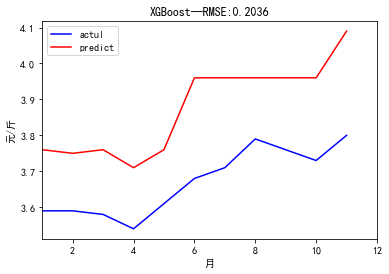

2.3600003433227545

In [8]:
#解决中文显示问题
from pylab import mpl
# 设置显示中文字体 
mpl.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.plot(y_predict,color='blue',label='actul')
plt.plot(Y_predict,color='red',label='predict')
plt.legend(loc='best')
plt.xlim((1,12))
plt.ylabel('元/斤')
plt.xlabel('月')
plt.title('XGBoost—RMSE:%.4f'%np.sqrt((sum((Y_predict-y_predict)**2))/len(Y_predict)))
plt.show()
sum(np.absolute(Y_predict-y_predict))

In [9]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [10]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=tweaked_model.best_params_['learning_rate'], 
                       n_estimators=tweaked_model.best_params_['n_estimators'],
                        )
# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=tweaked_model.best_params_['n_estimators'],
                          max_depth = tweaked_model.best_params_['max_depth'],
                        )

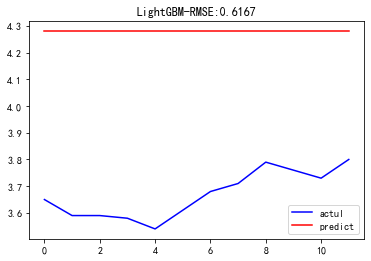

7.330000000000004

In [11]:
lgb_model_full_data = lightgbm.fit(x_train, y_train)
Y_predict = lgb_model_full_data.predict(x_predict).round(2)
plt.plot(y_predict,color='blue',label='actul')
plt.plot(Y_predict,color='red',label='predict')
plt.legend(loc='best')
plt.title('LightGBM-RMSE:%.4f'%np.sqrt((sum((Y_predict-y_predict)**2))/len(Y_predict)))
plt.show()
sum(np.absolute(Y_predict-y_predict))

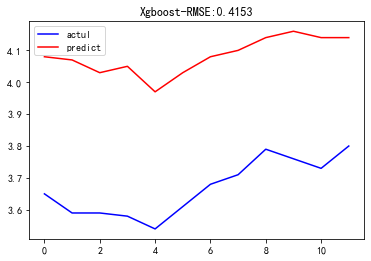

4.960000000000001

In [12]:
svr_model_full_data = svr.fit(x_train, y_train)
Y_predict = svr_model_full_data.predict(x_predict).round(2)
plt.plot(y_predict,color='blue',label='actul')
plt.plot(Y_predict,color='red',label='predict')
plt.legend(loc='best')
plt.title('Xgboost-RMSE:%.4f'%np.sqrt((sum((Y_predict-y_predict)**2))/len(Y_predict)))
plt.show()
sum(np.absolute(Y_predict-y_predict))

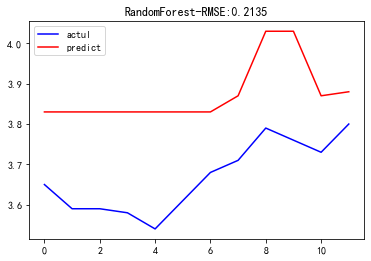

2.4600000000000017

In [14]:
rf_model_full_data = rf.fit(x_train, y_train)
Y_predict = rf_model_full_data.predict(x_predict).round(2)
plt.plot(y_predict,color='blue',label='actul')
plt.plot(Y_predict,color='red',label='predict')
plt.legend(loc='best')
plt.title('RandomForest-RMSE:%.4f'%np.sqrt((sum((Y_predict-y_predict)**2))/len(Y_predict)))
plt.show()
sum(np.absolute(Y_predict-y_predict))

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [27]:
window=1#时间窗设置
#这一部分在处理数据 将原始数据改造为LSTM网络的输入
stock=df.iloc[5:,1: ]
stock = stock.reset_index(drop=True)
order = ['mov_ori_avg','mov_ori_max','mov_ori_min','mov_ori_var','滑窗产地价格波动','滑窗产地价格波动率','orign_price']
stock = stock[order]
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.values #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度+1
result = []
for index in range(len(data) - sequence_length):#循环 数据长度-时间窗长度 次
    result.append(data[index: index + sequence_length])#第i行到i+5
result = np.array(result)#得到样本，样本形式为 window*feanum
cut=12#分训练集测试集 最后cut个样本为测试集
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features)) 

In [28]:
#展示下训练集测试集的形状 看有没有问题
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (20, 1, 7)
y_train (20,)
X_test (12, 1, 7)
y_test (12,)


In [29]:
#建立、训练模型过程
d = 0.01
model = Sequential()#建立层次模型
model.add(LSTM(32, input_shape=(window, amount_of_features), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(16, input_shape=(window, amount_of_features), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(Dense(2,activation='relu'))   #建立全连接层     
model.add(Dense(1,activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, y_train, epochs =100, batch_size = 128) #训练模型nb_epoch次

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 18.6675 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 18.5695 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 18.4742 - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 18.3714 - accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 18.2806 - accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 18.1847 - accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 18.0896 - accuracy: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 17.9719 - accuracy: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 17.8568 - accuracy: 0.0000e+00
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 17.7595 - a

1/1 [==============================] - 0s 5ms/step - loss: 2.0525 - accuracy: 0.0000e+00
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6368 - accuracy: 0.0000e+00
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5316 - accuracy: 0.0000e+00
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4068 - accuracy: 0.0000e+00
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2651 - accuracy: 0.0000e+00
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2103 - accuracy: 0.0000e+00
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0259 - accuracy: 0.0000e+00
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 0.9343 - accuracy: 0.0000e+00
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 0.8770 - accuracy: 0.0000e+00
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 0.7215 - accuracy: 0.00

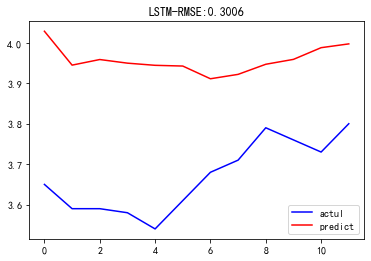

3.4632150840759284

In [31]:
#在训练集上的拟合结果
Y_predict=model.predict(X_test)[:,0]
plt.plot(y_predict,color='blue',label='actul')
plt.plot(Y_predict,color='red',label='predict')
plt.legend(loc='best')
plt.title('LSTM-RMSE:%.4f'%np.sqrt((sum((Y_predict-y_predict)**2))/len(Y_predict)))
plt.show()
sum(np.absolute(Y_predict-y_predict))